In [1]:
using Pkg; Pkg.activate("/home/dhairyagandhi96/modelzoo/model-zoo/script/../other/diffeq"); Pkg.instantiate(); Pkg.add(PackageSpec(name="CUDAdrv", rev = "master")); Pkg.add(PackageSpec(name="CUDAnative", rev = "master")); Pkg.add(PackageSpec(name="CuArrays", rev = "master")); Pkg.add(PackageSpec(name="Flux", rev = "master"))

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Updating git-repo `https://github.com/JuliaGPU/CUDAdrv.jl.git`
 Resolving package versions...
  Updating `~/modelzoo/model-zoo/other/diffeq/Project.toml`
 [no changes]
  Updating `~/modelzoo/model-zoo/other/diffeq/Manifest.toml`
 [no changes]
  Updating git-repo `https://github.com/JuliaGPU/CUDAnative.jl.git`
 Resolving package versions...
  Updating `~/modelzoo/model-zoo/other/diffeq/Project.toml`
 [no changes]
  Updating `~/modelzoo/model-zoo/other/diffeq/Manifest.toml`
 [no changes]
  Updating git-repo `https://github.com/JuliaGPU/CuArrays.jl.git`
 Resolving package versions...
  Updating `~/modelzoo/model-zoo/other/diffeq/Project.toml`
 [no changes]
  Updating `~/modelzoo/model-zoo/other/diffeq/Manifest.toml`
 [no changes]
  Updating git-repo `https://github.com/FluxML/Flux.jl.git`
 Resolving package versions...
  Updating `~/modelzoo/model-zoo/other/diffeq/Pr

This script illustrates backpropagation through a simulation, via Flux,
DifferentialEquations and ForwardDiff. Flux's ADAM optimiser and training loop
are then used to optimise parameters of the simulation.

In [2]:
using OrdinaryDiffEq, Plots

––––––––––––––––––––––––––––––––––––––––––––––––––––– #
                     ODE setup                        #
––––––––––––––––––––––––––––––––––––––––––––––––––––– #

The ODE

In [3]:
function lotka_volterra(du,u,p,t)
  x, y = u
  α, β, δ, γ = p
  du[1] = dx = (α - β*y)x
  du[2] = dy = (δ*x - γ)y
end

const initial_pop = 1

1

Solve the ODE with a given set of parameters, to see how the predator/prey
populations behave over time.

In [4]:
function trajectory(predator, prey, tfinal = 10)
  params = [predator..., prey...]
  T = eltype(params)
  u0 = T.([initial_pop, initial_pop])
  tspan = (T(0), T(tfinal))
  prob = ODEProblem(lotka_volterra, u0, tspan, params)
  solve(prob, Tsit5(), dtmin = 1e-4)
end

trajectory (generic function with 2 methods)

See an example solution

┌ Warning: `binary_minheap(xs::AbstractVector{T}) where T` is deprecated, use `BinaryMinHeap(xs)` instead.
│   caller = #__init#203(::Int64, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Nothing, ::Bool, ::Nothing, ::Bool, ::Bool, ::Bool, ::Nothing, ::Bool, ::Bool, ::Float64, ::Bool, ::Rational{Int64}, ::Nothing, ::Nothing, ::Int64, ::Rational{Int64}, ::Int64, ::Int64, ::Rational{Int64}, ::Bool, ::Int64, ::Nothing, ::Nothing, ::Int64, ::Float64, ::Float64, ::typeof(DiffEqBase.ODE_DEFAULT_NORM), ::typeof(LinearAlgebra.opnorm), ::typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), ::typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), ::Bool, ::Bool, ::Bool, ::Bool, ::Bool, ::Bool, ::Bool, ::Bool, ::Int64, ::String, ::typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), ::Nothing, ::Bool, ::Bool, ::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::typeof(DiffEqBase.__init), ::DiffEqBase.ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},DiffEqBase.

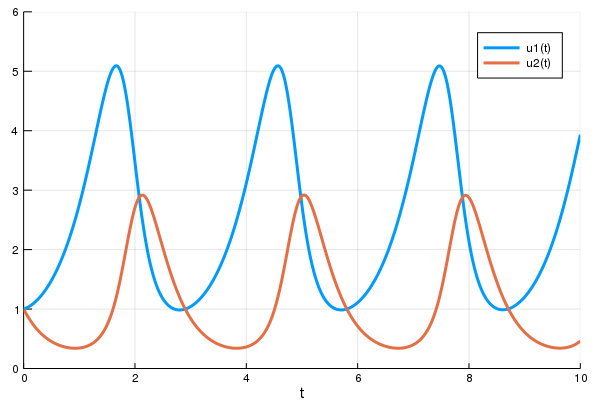

In [5]:
plot(trajectory([1.8, 1.5], [1.2, 3]), ylim=(0,6))

For now, our loss is the deviation from the initial population;
we are optimising for stability.

In [6]:
function stability(sol::ODESolution)
  sol.retcode != :Success && return zero(sol.u[1][1])
  series = sol.(range(0, stop = 10, length = 50))
  sum(x -> sum(x -> (x - initial_pop)^2, x), series)/length(series)
end

stability(predator, prey, tfinal = 100) =
  stability(trajectory(predator, prey, tfinal))
# Preview the loss
stability([1.8, 1.5], [1.2, 3])

┌ Warning: `binary_minheap(xs::AbstractVector{T}) where T` is deprecated, use `BinaryMinHeap(xs)` instead.
│   caller = #__init#203(::Int64, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Nothing, ::Bool, ::Nothing, ::Bool, ::Bool, ::Bool, ::Nothing, ::Bool, ::Bool, ::Float64, ::Bool, ::Rational{Int64}, ::Nothing, ::Nothing, ::Int64, ::Rational{Int64}, ::Int64, ::Int64, ::Rational{Int64}, ::Bool, ::Int64, ::Nothing, ::Nothing, ::Int64, ::Float64, ::Float64, ::typeof(DiffEqBase.ODE_DEFAULT_NORM), ::typeof(LinearAlgebra.opnorm), ::typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), ::typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), ::Bool, ::Bool, ::Bool, ::Bool, ::Bool, ::Bool, ::Bool, ::Bool, ::Int64, ::String, ::typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), ::Nothing, ::Bool, ::Bool, ::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::typeof(DiffEqBase.__init), ::DiffEqBase.ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},DiffEqBase.

4.626058215947293

––––––––––––––––––––––––––––––––––––––––––––––––––––– #
                     Autodiff                         #
––––––––––––––––––––––––––––––––––––––––––––––––––––– #

In [7]:
using Flux
import Flux.Tracker: TrackedVector, @grad, track
using ForwardDiff: Dual, value, partials

Provide a custom gradient for `stability`, which will use forward-mode AD
internally.

In [8]:
stability(predator::TrackedVector, prey) = track(stability, predator, prey)

@grad function stability(predator, prey)
  s = stability(Tracker.data(predator) .+ [Dual(0,1,0),Dual(0,0,1)], prey)
  value(s), Δ -> (Δ .* partials(s), nothing)
end

Now we can take gradients w.r.t. the parameters.

In [9]:
pred = [2.2, 1.0]
prey = [2, 3]
Tracker.gradient(p -> stability(p, prey), pred, nest = true)

┌ Warning: `binary_minheap(xs::AbstractVector{T}) where T` is deprecated, use `BinaryMinHeap(xs)` instead.
│   caller = tstop_saveat_disc_handling at solve.jl:372 [inlined]
└ @ Core /home/dhairyagandhi96/.julia/packages/OrdinaryDiffEq/RrY3s/src/solve.jl:372
┌ Warning: `binary_minheap(xs::AbstractVector{T}) where T` is deprecated, use `BinaryMinHeap(xs)` instead.
│   caller = #__init#203(::Int64, ::Array{ForwardDiff.Dual{Nothing,Float64,2},1}, ::Array{ForwardDiff.Dual{Nothing,Float64,2},1}, ::Array{ForwardDiff.Dual{Nothing,Float64,2},1}, ::Nothing, ::Bool, ::Nothing, ::Bool, ::Bool, ::Bool, ::Nothing, ::Bool, ::Bool, ::ForwardDiff.Dual{Nothing,Float64,2}, ::Bool, ::Rational{Int64}, ::Nothing, ::Nothing, ::Int64, ::Rational{Int64}, ::Int64, ::Int64, ::Rational{Int64}, ::Bool, ::Int64, ::Nothing, ::Nothing, ::Int64, ::ForwardDiff.Dual{Nothing,Float64,2}, ::Float64, ::typeof(DiffEqBase.ODE_DEFAULT_NORM), ::typeof(LinearAlgebra.opnorm), ::typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), ::type

([4.63595, -12.232],)

––––––––––––––––––––––––––––––––––––––––––––––––––––– #
              Optimising Parameters                   #
––––––––––––––––––––––––––––––––––––––––––––––––––––– #

In [10]:
predator = param([2.2, 1.0])
prey = [2, 3]

data = Iterators.repeated((), 100)
opt = ADAM([predator], 0.1)
#cb = () ->

┌ Warning: ADAM(params) is deprecated; use ADAM(η::Float64) instead
│   caller = top-level scope at none:0
└ @ Core none:0


#13 (generic function with 1 method)

 display(plot(trajectory(Flux.data(predator), prey), ylim=(0,6)))

Display the ODE with the current parameter values.

In [11]:
#cb()

Running this in Juno will generate an animation of the ODE over time.

In [12]:
Flux.train!(() -> stability(predator, prey),
            data, opt)

┌ Warning: train!(loss, data, opt) is deprecated; use train!(loss, params, data, opt) instead
│   caller = top-level scope at none:0
└ @ Core none:0
┌ Warning: `binary_minheap(xs::AbstractVector{T}) where T` is deprecated, use `BinaryMinHeap(xs)` instead.
│   caller = tstop_saveat_disc_handling at solve.jl:372 [inlined]
└ @ Core /home/dhairyagandhi96/.julia/packages/OrdinaryDiffEq/RrY3s/src/solve.jl:372
┌ Warning: `binary_minheap(xs::AbstractVector{T}) where T` is deprecated, use `BinaryMinHeap(xs)` instead.
│   caller = #__init#203(::Int64, ::Array{ForwardDiff.Dual{Nothing,Float64,2},1}, ::Array{ForwardDiff.Dual{Nothing,Float64,2},1}, ::Array{ForwardDiff.Dual{Nothing,Float64,2},1}, ::Nothing, ::Bool, ::Nothing, ::Bool, ::Bool, ::Bool, ::Nothing, ::Bool, ::Bool, ::ForwardDiff.Dual{Nothing,Float64,2}, ::Bool, ::Rational{Int64}, ::Nothing, ::Nothing, ::Int64, ::Rational{Int64}, ::Int64, ::Int64, ::Rational{Int64}, ::Bool, ::Int64, ::Nothing, ::Nothing, ::Int64, ::ForwardDiff.Dual{Nothing